In [1]:
import random
import os
import cv2
import imutils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.segmentation import clear_border
from imutils.perspective import four_point_transform
from collections import defaultdict
from keras.models import load_model

model = load_model('./cnn_model_printed_digits_bt32_E14.h5')

In [2]:
def find_puzzle(imgPath, debug=False):
    img = cv2.imread(imgPath, cv2.CV_8UC1)
    grayimg = cv2.imread(imgPath)
    gray = cv2.cvtColor(grayimg, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap="gray")
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc = cv2.bitwise_not(proc, proc)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    proc = cv2.dilate(proc, kernel)
    cnts = cv2.findContours(proc.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    puzzleCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            puzzleCnt = approx
            break
    if puzzleCnt is None:
        raise Exception(("Could not find Sudoku puzzle outline. "
                         "Try debugging your thresholding and contour steps."))
    puzzle = four_point_transform(img, puzzleCnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))
    puzzle = cv2.resize(puzzle, (666, 666), interpolation=cv2.INTER_CUBIC)
    return puzzle, warped

In [3]:
def imgcrop(input, x, y):
    w, h = input.shape
    height = h // y
    width = w // x
    crop_img = defaultdict(dict)
    for i in range(0, y):
        for j in range(0, x):
            crop_img[i][j] = input[(height * i):height * (i + 1), (j * width):width * (j + 1)]
    return crop_img

In [4]:
def extract_digit(cell, flag):
    thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return 0
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)
    if percentFilled < 0.005:
#         print("Little Data")
        return 0
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    img = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_CUBIC)
    img = cv2.bitwise_not(img)
    name = './digit_data/tmp_' + str(flag) + '.png'
    cv2.imwrite(name, img)
    img = cv2.imread(name, 0)  
    X = img / 255.0
    X = X.reshape(-1, 28, 28, 1)
    res = model.predict(X)
    return np.argmax(res)

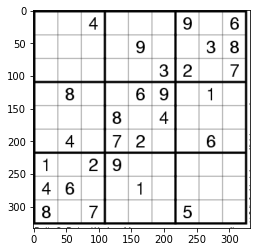

In [5]:
imgpath = './sudoku1.PNG'
img = cv2.imread(imgpath)
puzzle, warped = find_puzzle(imgpath)
# plt.imshow(img)

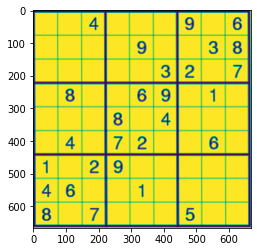

In [6]:
plt.imshow(puzzle)

In [7]:
n = 9
t = []
cells = imgcrop(puzzle, n, n)
flag = 0
for i in range(0, n):
    r = []
    for j in range(0, n):
        r = np.append(r, extract_digit(cells[i][j], flag))
        flag = flag + 1
    t = np.append(t, r)
r = t.reshape(9, 9)
r = r.astype(int)
print(r)

[[0 0 4 0 0 0 9 0 6]
 [0 0 0 0 9 0 0 3 8]
 [0 0 0 0 0 3 2 0 7]
 [0 8 0 0 6 9 0 1 0]
 [0 0 0 8 0 4 0 0 0]
 [0 4 0 7 2 0 0 6 0]
 [1 0 2 9 0 0 0 0 0]
 [4 6 0 0 1 0 0 0 0]
 [3 0 7 0 0 0 5 0 0]]


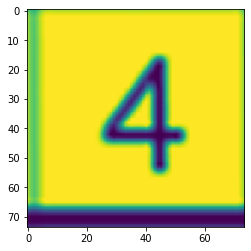

In [8]:
rowIndex = 5
colIndex = 1

plt.imshow(cells[rowIndex][colIndex])

In [9]:
r[rowIndex][colIndex]

4